In [20]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import contextily as ctx
import sklearn.cluster
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [21]:
def make_geo(df: pd.DataFrame) -> geopandas.GeoDataFrame:
    """ Konvertovani dataframe do geopandas.GeoDataFrame se spravnym kodovani"""
    df['p2a'] = df['p2a'].astype('datetime64')
    df.rename(columns={'p2a': 'date'}, inplace=True)
    df = df.dropna(subset=['d','e'])
    return geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df['d'], df['e']), crs="epsg:5514")

gdf = make_geo(pd.read_pickle("accidents.pkl.gz"))

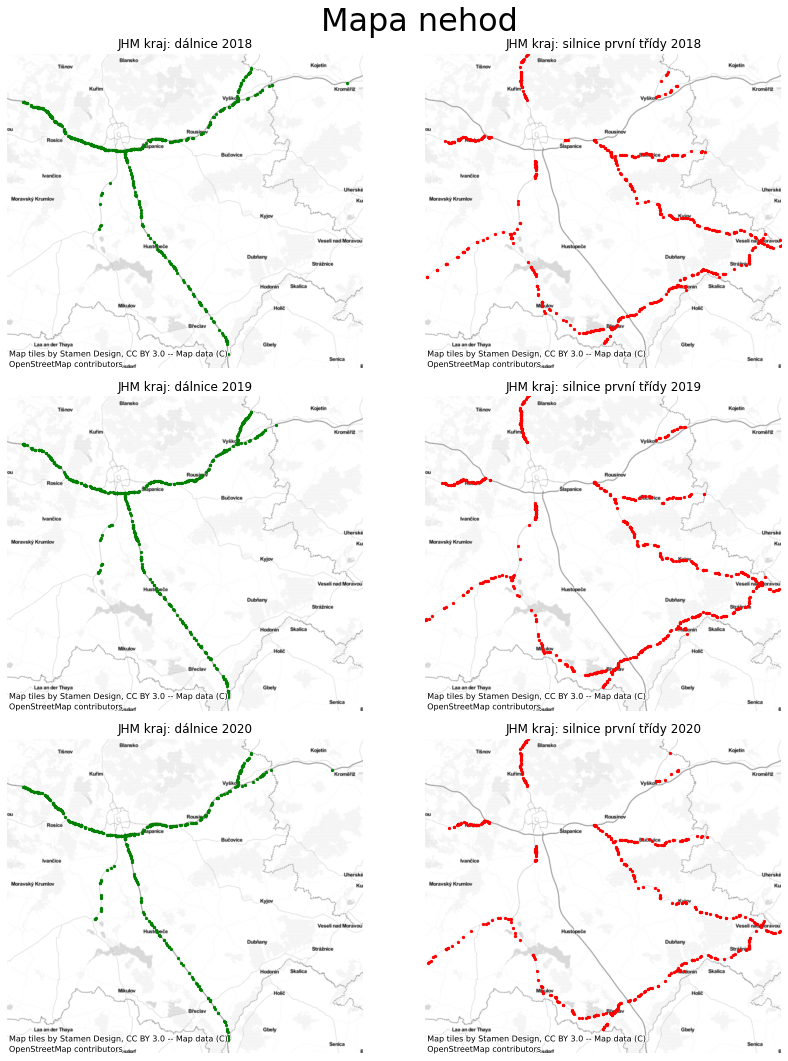

In [22]:
def plot_geo(gdf: geopandas.GeoDataFrame, fig_location: str = None,
             show_figure: bool = False):
    """ Vykresleni grafu s sesti podgrafy podle lokality nehody
     (dalnice vs prvni trida) pro roky 2018-2020 """
    gdf_jhm = gdf[gdf['region']=='JHM'].to_crs('epsg:3857')
    fig, axs = plt.subplots(3,2,figsize=(12,15))
    static = {'clr': ['green','red'], 'road':['dálnice', 'silnice první třídy']}
    for i in range(3):
        for p in range(2):
            axs[i,p].axis('off')
            gdf_jhm[(gdf_jhm['p36']==p) & (gdf_jhm['date'].dt.year == 2018+i)].plot(ax=axs[i,p],markersize=5, color=static['clr'][p])
            axs[i,p].title.set_text('JHM kraj: '+ static['road'][p] + " " +str(2018+i))
            axs[i,p].set_ylim(axs[0,0].get_ylim())
            axs[i,p].set_xlim(axs[0,0].get_xlim())
            ctx.add_basemap(axs[i,p],crs=gdf_jhm.crs.to_string(),source=ctx.providers.Stamen.TonerLite)
            #ctx.providers.CartoDB.Positron ctx.providers.Stamen.TonerLite ctx.providers.NASAGIBS.ViirsEarthAtNight2012

    fig.suptitle("Mapa nehod", fontsize=32)
    plt.tight_layout()

    if fig_location:
        plt.savefig(fig_location)

    if show_figure:
        plt.show()
        plt.close()
plot_geo(gdf, None, True)

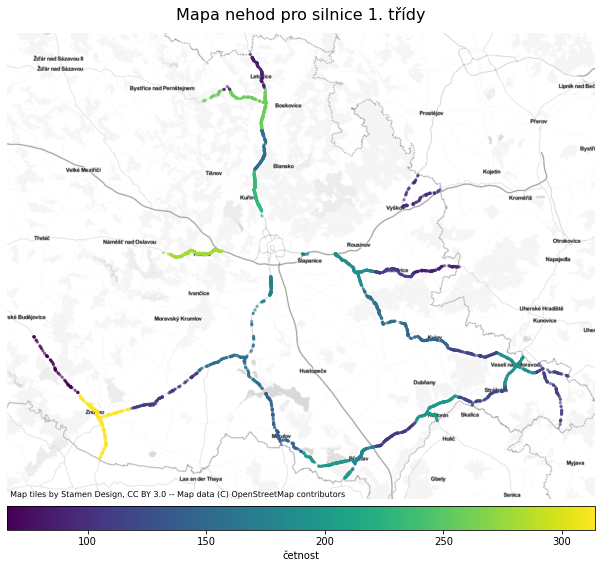

In [23]:
def plot_cluster(gdf: geopandas.GeoDataFrame, fig_location: str = None,
                 show_figure: bool = False):
    """ Vykresleni grafu s lokalitou vsech nehod v kraji shlukovanych do clusteru """
    gdf_jhm = gdf[(gdf['region']=='JHM') & (gdf['p36']==1)].to_crs('epsg:3857')
    gdf_jhm = gdf_jhm.reset_index()
    cords = np.dstack([gdf_jhm.geometry.x, gdf_jhm.geometry.y]).reshape(-1, 2)
    gdf_jhm['cluster'] = sklearn.cluster.MiniBatchKMeans(n_clusters=25).fit(cords).labels_
    gdf_jhm = gdf_jhm.dissolve(by='cluster', aggfunc={'p1':'count'}).rename(columns={'p1':'cnt'})

    fig, ax = plt.subplots(1,1, figsize=(10,8))
    cax = make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0.1)
    gdf_jhm.plot(ax=ax,cax=cax, column='cnt', alpha=0.5, markersize=5, legend=True, legend_kwds={'label': 'četnost', 'orientation': 'horizontal'})
    ctx.add_basemap(ax=ax,crs=gdf_jhm.crs.to_string(),source=ctx.providers.Stamen.TonerLite)
    ax.axis('off')
    fig.suptitle("Mapa nehod pro silnice 1. třídy", fontsize=16)
    plt.tight_layout()

    if fig_location:
        plt.savefig(fig_location)

    if show_figure:
        plt.show()
        plt.close()

plot_cluster(gdf, None, True)